This script generates the average face for the distance-based analysis as well as saving the individual masked images used to generate the average.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np
import pandas as pd

import skimage.io as io
io.use_plugin('matplotlib')

import menpo
import menpo.io as mio
from menpowidgets import visualize_images
from pathlib import Path

from tqdm import tqdm

## Load

In [2]:
unfam_df = pd.read_csv("/data1/famface01/analysis/encoding/12_Features/unfam_final_frame_df.csv")
unfam_df = unfam_df.ix[:,1:]
unfam_df.head()

,vnum,vid,frame,category,fpath
0,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,3,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
1,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,9,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
2,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,15,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
3,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,21,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
4,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,27,unfam,/data1/famface01/data/stimuli/vids/eight_frame...


In [3]:
from menpo.landmark import face_ibug_68_to_face_ibug_68_trimesh, face_ibug_68_to_face_ibug_68, labeller

unfam_images = []
for i,row in tqdm(unfam_df.iterrows(), total=len(unfam_df)):
    img = mio.import_image(row.fpath)
    img = img.crop_to_landmarks_proportion(0.1)
    labeller(img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    unfam_images.append(img)

100%|██████████| 6912/6912 [03:28<00:00, 33.15it/s]


In [ ]:
img = unfam_images[1]
img.landmarks.keys()

In [77]:
from menpo.shape import mean_pointcloud, PointCloud
from menpofit.builder import (compute_reference_shape, rescale_images_to_reference_shape, 
                              warp_images, build_reference_frame, align_shapes)
from menpofit.transform import DifferentiablePiecewiseAffine

diagonal = 200
verbose = True
group = 'face_ibug_68_trimesh'

ref_shape = compute_reference_shape([i.landmarks[group].lms for i in unfam_images], diagonal, verbose=verbose)

- Computing reference shape                                                     

In [78]:
shape_batch = [i.landmarks[group].lms for i in unfam_images]
mean_aligned_shape = mean_pointcloud(align_shapes(shape_batch))
reference_frame = build_reference_frame(mean_aligned_shape)

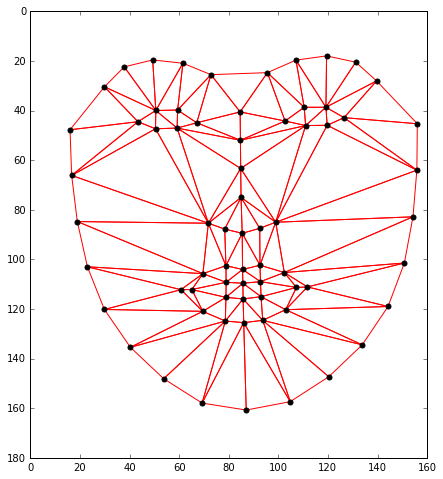

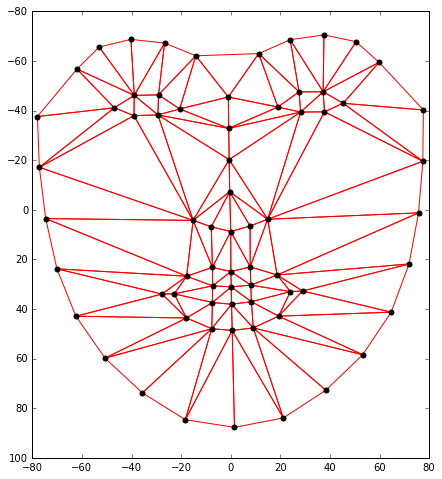

In [79]:
# Ref shape is the literal position
# While the aligned shape has been centered
ref_shape.view(new_figure=True)
mean_aligned_shape.view(new_figure=True)

In [80]:
image_batch = rescale_images_to_reference_shape(unfam_images, group, mean_aligned_shape, verbose=verbose)
shape_batch = [i.landmarks[group].lms for i in image_batch]

- Normalizing images size: [==========] 100% (6912/6912) - done.                

In [81]:
scale_prefix = '  - '
warped_images = warp_images(image_batch, shape_batch, reference_frame, DifferentiablePiecewiseAffine,
                               prefix=scale_prefix, verbose=True)

  - Warping images: [==========] 100% (6912/6912) - done.                       

In [ ]:
visualize_images(warped_images)

In [82]:
imgs = np.array([ img.pixels for img in warped_images ])
ave_img0 = np.mean(imgs, axis=0)
print ave_img0.shape

ave_shape = PointCloud(mean_aligned_shape.points + np.array([(165-18)/2.,(162)/2.])[np.newaxis,:])
ave_img = menpo.image.Image(ave_img0)
ave_img.landmarks['PTS'] = ave_shape
labeller(ave_img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)

(3, 165, 162)


162W x 165H 2D Image with 3 channels

In [ ]:
ave_img.view_landmarks(group='face_ibug_68_trimesh')
ave_img.view_landmarks(group='PTS', new_figure=True)

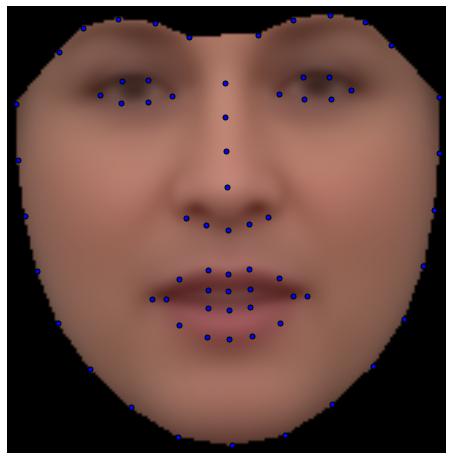

In [83]:
ave_img.view_landmarks(group='PTS')

In [8]:
#from menpo.image.masked import MaskedImage
masked_images = [ img.as_masked().constrain_mask_to_landmarks(group='face_ibug_68_trimesh') for img in tqdm(unfam_images) ]

100%|██████████| 6912/6912 [15:12<00:00,  3.91it/s]


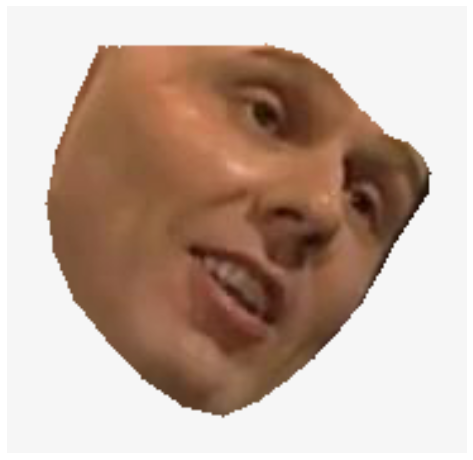

In [22]:
#visualize_images(masked_images)
masked_images[40].view()

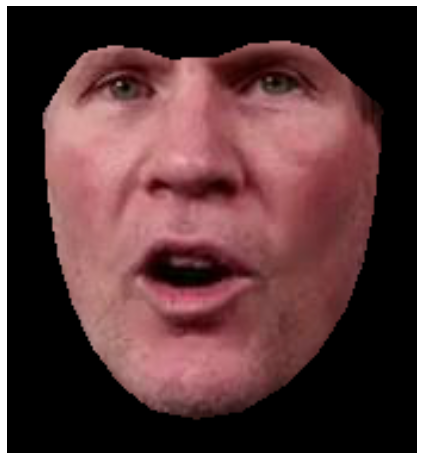

In [44]:
mimg = masked_images[1]
menpo.image.Image(mimg.pixels * mimg.mask.pixels).view()

## Save

In [23]:
from menpo.io.output import export_image, export_landmark_file

odir = '/data1/famface01/data/stimuli/vids/masked_images'
if not os.path.exists(odir): os.mkdir(odir)

In [27]:
export_image(ave_img, '%s/average_face2.jpg' % odir, overwrite=True)
export_landmark_file(ave_img.landmarks['PTS'], '%s/average_face2.pts' % odir, overwrite=True)

In [46]:
for i,row in tqdm(unfam_df.iterrows(), total=unfam_df.shape[0]):
    mimg = masked_images[i]
    mimg = menpo.image.Image(mimg.pixels * mimg.mask.pixels)
    mimg.landmarks['PTS'] = masked_images[i].landmarks['PTS'].lms
    end_path = row.fpath.replace('/data1/famface01/data/stimuli/vids/eight_frames/final/', '')
    end_land_path = end_path.replace('.jpg', '.pts')
    
    base_dir = "%s/%s" % (odir, os.path.dirname(end_path))
    if not os.path.exists(base_dir): os.mkdir(base_dir)
    
    export_image(mimg, '%s/%s' % (odir, end_path), overwrite=True)
    export_landmark_file(mimg.landmarks['PTS'], '%s/%s' % (odir, end_land_path), overwrite=True)

100%|██████████| 6912/6912 [01:53<00:00, 56.47it/s]


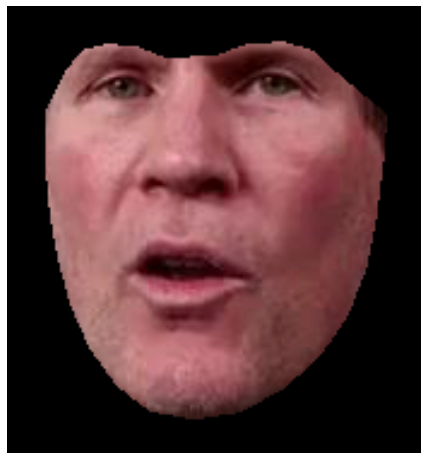

In [73]:
i = 0
mimg = masked_images[i]
mimg = menpo.image.Image(mimg.pixels * mimg.mask.pixels)
mimg.landmarks['PTS'] = masked_images[i].landmarks['PTS'].lms

mimg.view()

In [ ]:
istart = 4
id_ave_img0 = np.mean(np.array([ img.pixels for img in warped_images[(istart*8):(istart*8+8)] ]), axis=0)
id_ave_shape0 = mean_pointcloud([i.landmarks['source'].lms for i in warped_images[:8]])

id_ave_img = menpo.image.Image(id_ave_img0)
id_ave_img.landmarks['PTS'] = id_ave_shape0
labeller(id_ave_img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)

id_ave_img.view()

## Gender Prototypes

### Load info

In [51]:
import re
df_demos = pd.read_csv("/data1/famface01/analysis/encoding/12_Features/demographics_unfam_df.csv")
df_demos['vid'] = [ re.sub('_fr.*$', '', v) for v in df_demos.video ]
df_demos.head()

,Unnamed: 0,batch,video,age,facial_hair,makeup,gender,race,hair,eye,glasses,vid
0,Aaron_Sorkin,0,Aaron_Sorkin_vid03_clip01_2secs_fr045,3.166667,None,0.750000,Male,White,Brown,Brown,Yes,Aaron_Sorkin_vid03_clip01_2secs
1,Abdullah,0,Abdullah_vid02_clip01_2secs_fr039,1.333333,Goatee and moustache,0.083333,Male,Black,Black,Brown,No,Abdullah_vid02_clip01_2secs
2,Agnes_Bruckner,0,Agnes_Bruckner_vid02_clip05_2secs_fr003,1.916667,None,1.416667,Female,White,Blonde,Brown,No,Agnes_Bruckner_vid02_clip05_2secs
3,Abba_Eban,0,Abba_Eban_vid03_clip18_2secs_fr033,5.583333,None,0.416667,Male,White,White,Brown,No,Abba_Eban_vid03_clip18_2secs
4,Aisha_Hinds,0,Aisha_Hinds_vid05_clip02_2secs_fr027,2.250000,None,1.750000,Female,Black,Black,Brown,No,Aisha_Hinds_vid05_clip02_2secs


In [47]:
unfam_df.head()

,vnum,vid,frame,category,fpath
0,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,3,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
1,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,9,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
2,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,15,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
3,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,21,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
4,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,27,unfam,/data1/famface01/data/stimuli/vids/eight_frame...


In [63]:
demo_inds = [ np.nonzero(v == df_demos.vid)[0][0] for v in unfam_df.vid ]
unfam_df['gender'] = df_demos.gender[demo_inds].tolist()
unfam_df.head()

,vnum,vid,frame,category,fpath,gender
0,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,3,unfam,/data1/famface01/data/stimuli/vids/eight_frame...,Male
1,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,9,unfam,/data1/famface01/data/stimuli/vids/eight_frame...,Male
2,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,15,unfam,/data1/famface01/data/stimuli/vids/eight_frame...,Male
3,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,21,unfam,/data1/famface01/data/stimuli/vids/eight_frame...,Male
4,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,27,unfam,/data1/famface01/data/stimuli/vids/eight_frame...,Male


### Make Prototypes

In [64]:
from menpo.shape import mean_pointcloud, PointCloud
from menpofit.builder import (compute_reference_shape, rescale_images_to_reference_shape, 
                              warp_images, build_reference_frame, align_shapes)
from menpofit.transform import DifferentiablePiecewiseAffine
from menpo.io.output import export_image, export_landmark_file

diagonal = 200
verbose = True
group = 'face_ibug_68_trimesh'

In [68]:
# Male

## reference
print 'ref'
shape_batch = [img.landmarks[group].lms for i,img in enumerate(unfam_images) if unfam_df.gender[i] == 'Male']
ref_shape = compute_reference_shape(shape_batch, diagonal, verbose=verbose)
mean_aligned_shape = mean_pointcloud(align_shapes(shape_batch))
reference_frame = build_reference_frame(mean_aligned_shape)

## image/shape batches
print 'batches'
image_batch = rescale_images_to_reference_shape(np.array(unfam_images)[unfam_df.gender=='Male'], group, mean_aligned_shape, verbose=verbose)
shape_batch = [i.landmarks[group].lms for i in image_batch]

## warp
print 'warp'
scale_prefix = '  - '
warped_images = warp_images(image_batch, shape_batch, reference_frame, DifferentiablePiecewiseAffine,
                               prefix=scale_prefix, verbose=True)

## get average
imgs = np.array([ img.pixels for img in warped_images ])
ave_img0 = np.mean(imgs, axis=0)
ave_shape = PointCloud(mean_aligned_shape.points + np.array([(165-18)/2.,(162)/2.])[np.newaxis,:])
ave_img = menpo.image.Image(ave_img0)
ave_img.landmarks['PTS'] = ave_shape
labeller(ave_img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)

## rename
ave_img_male = ave_img

ref
- Computing reference shape                                                     batches
- Normalizing images size: [==========] 100% (3456/3456) - done.                warp
  - Warping images: [==========] 100% (3456/3456) - done.                       

In [69]:
# Female

## reference
print 'ref'
shape_batch = [img.landmarks[group].lms for i,img in enumerate(unfam_images) if unfam_df.gender[i] == 'Female']
ref_shape = compute_reference_shape(shape_batch, diagonal, verbose=verbose)
mean_aligned_shape = mean_pointcloud(align_shapes(shape_batch))
reference_frame = build_reference_frame(mean_aligned_shape)

## image/shape batches
print 'batches'
image_batch = rescale_images_to_reference_shape(np.array(unfam_images)[unfam_df.gender=='Female'], group, mean_aligned_shape, verbose=verbose)
shape_batch = [i.landmarks[group].lms for i in image_batch]

## warp
print 'warp'
scale_prefix = '  - '
warped_images = warp_images(image_batch, shape_batch, reference_frame, DifferentiablePiecewiseAffine,
                               prefix=scale_prefix, verbose=True)

## get average
imgs = np.array([ img.pixels for img in warped_images ])
ave_img0 = np.mean(imgs, axis=0)
ave_shape = PointCloud(mean_aligned_shape.points + np.array([(165-18)/2.,(162)/2.])[np.newaxis,:])
ave_img = menpo.image.Image(ave_img0)
ave_img.landmarks['PTS'] = ave_shape
labeller(ave_img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)

## rename
ave_img_female = ave_img

ref
- Computing reference shape                                                     batches
- Normalizing images size: [==========] 100% (3456/3456) - done.                warp
  - Warping images: [==========] 100% (3456/3456) - done.                       

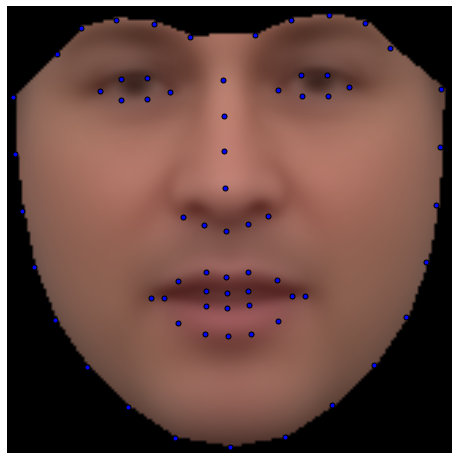

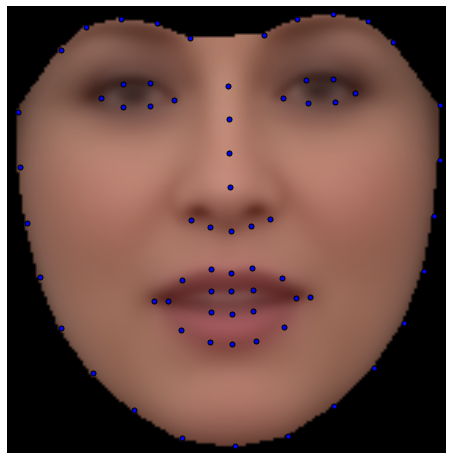

In [70]:
ave_img_male.view_landmarks(group='PTS')
ave_img_female.view_landmarks(group='PTS', new_figure=True)

### Save

In [71]:
odir = '/data1/famface01/data/stimuli/vids/masked_images/prototypes'
if not os.path.exists(odir): os.mkdir(odir)

export_image(ave_img_male, '%s/average_face_male.jpg' % odir, overwrite=True)
export_landmark_file(ave_img_male.landmarks['PTS'], '%s/average_face_male.pts' % odir, overwrite=True)

export_image(ave_img_female, '%s/average_face_female.jpg' % odir, overwrite=True)
export_landmark_file(ave_img_female.landmarks['PTS'], '%s/average_face_female.pts' % odir, overwrite=True)

## Neural Network Setup

We now copy over the files to be used by the neural network. Note these command to be only run on hnl11.

In [ ]:
## DON'T RUN!

ssh hnl11

# Copy over files
mkdir ~/Downloads/tmp_masked_sf
mkdir ~/Downloads/tmp_masked_sf_nn
cp /data1/famface01/data/stimuli/vids/masked_images/*/*jpg ~/Downloads/tmp_masked_sf
cp /data1/famface01/data/stimuli/vids/masked_images/*/*pts ~/Downloads/tmp_masked_sf
cp /data1/famface01/data/stimuli/vids/masked_images/average_face.* ~/Downloads/tmp_masked_sf/
cp ~/Downloads/tmp_sf_nn/use-aligned.py ~/Downloads/tmp_masked_sf_nn/

# Connect
cd ~/Downloads/openface
sudo service docker start
sudo docker run -p 9000:9000 -p 8000:8000 -v ~/Downloads/tmp_masked_sf:/root/openface/masked_frames -v ~/Downloads/tmp_masked_sf_nn:/root/openface/nn_masked_frames -t -i bamos/openface /bin/bash

# Align
cd /root/openface
cp nn_masked_frames/use-aligned.py util/
mkdir nn_masked_frames/align
./util/use-aligned.py masked_frames align outerEyesAndNose nn_masked_frames/align --size 96
./batch-represent/main.lua -data nn_masked_frames/align -outDir nn_masked_frames/